## Import Data

- Import the raster file and store it in a variable lulc. LULC stands for land use/land cover.

- Import the tabular data and store it in a variable class_names.

In [4]:
import os
import numpy as np
import pandas as pd

import xarray as xr
import rioxarray as rioxr

In [2]:
# load in .tif file
lulc_fp = os.path.join(os.getcwd(),'data','land_cover.tif')
lulc = rioxr.open_rasterio(lulc_fp)
lulc

<xarray.DataArray (band: 1, y: 3000, x: 3000)>
[9000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.031e+06 -2.031e+06 ... -1.941e+06 -1.941e+06
  * y            (y) float64 1.762e+06 1.762e+06 ... 1.672e+06 1.672e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [7]:
# import the tabular data 
class_names = pd.read_csv('data/GAP_National_Terrestrial_Ecosystems.csv')
class_names.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


## Raster Exploration

CRS:  EPSG:5070
lulc # bands:  1


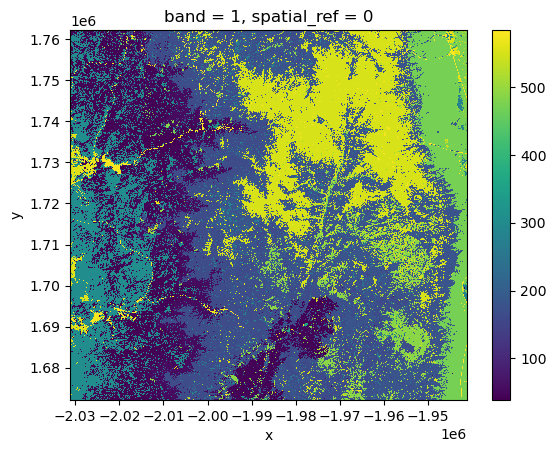

In [9]:
# plot the raster
lulc.plot()

# CRS for gc
print('CRS: ', lulc.rio.crs)

print('lulc # bands: ', lulc.rio.count)

## Raster Reduction

- How many dimensions does lulc cover have? If needed, get rid of unnecessary dimensions and verify your result.

In [11]:
# original dimensions and coordinates
print(lulc.dims, lulc.coords,'\n')

# remove length 1 dimension (band)
lulc = lulc.squeeze()
print(lulc.dims, lulc.coords,'\n')

# remove coordinates associated to band
lulc = lulc.drop('band')
print(lulc.dims, lulc.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.031e+06 -2.031e+06 ... -1.941e+06 -1.941e+06
  * y            (y) float64 1.762e+06 1.762e+06 ... 1.672e+06 1.672e+06
    spatial_ref  int64 0 

('y', 'x') Coordinates:
    band         int64 1
  * x            (x) float64 -2.031e+06 -2.031e+06 ... -1.941e+06 -1.941e+06
  * y            (y) float64 1.762e+06 1.762e+06 ... 1.672e+06 1.672e+06
    spatial_ref  int64 0 

('y', 'x') Coordinates:
  * x            (x) float64 -2.031e+06 -2.031e+06 ... -1.941e+06 -1.941e+06
  * y            (y) float64 1.762e+06 1.762e+06 ... 1.672e+06 1.672e+06
    spatial_ref  int64 0


## Percentage of area covered per class

### Pixels per Class

- Use the numpy function np.unique() to get the number of pixels per class in lulc. HINT: check the np.unique() documentation to see what the return_counts parameter does and read the last example.


In [22]:
# get the number of pixels per class in lulc
pixels = np.unique(lulc, return_counts=True)

### Organize Data

- Create a data frame pix_counts with two columns: column one must be the code numbers for the pixels in lulc and column two must be the number of pixels corresponding to each code. HINT: check our class notes.

In [24]:
# initialize dictionary with pixels arrays data 
pix = {'code' : pixels[0],
     'number_pixels' : pixels[1],
     }

# create data frame
pix_counts = pd.DataFrame(pix)
pix_counts



,code,number_pixels
0,39,639385
1,42,584143
2,56,518722
3,146,157
4,148,121486
...,...,...
56,579,36052
57,581,40296
58,582,12947
59,583,1955


### Add class names

- Use the class_names data frame to add the class names to the codes in the pix_counts data frame. Store the resulting data frame as classes.

In [29]:
# add class names
classes = pd.merge(pix_counts,
                   class_names,
                   how = 'left',
                   on = 'code')

# check to see if class_label was added
classes.head()

,code,number_pixels,class_label
0,39,639385,California Central Valley Mixed Oak Savanna
1,42,584143,California Lower Montane Blue Oak-Foothill Pin...
2,56,518722,Mediterranean California Mixed Oak Woodland
3,146,157,Inter-Mountain Basins Subalpine Limber-Bristle...
4,148,121486,Rocky Mountain Aspen Forest and Woodland


### Percentage covered

- Store the total number of pixels in lulc as a variable total_pixels without hard-coding any numbers. This means, calculate total_pixels from attributes of lulc.

- Add the percentage of area covered by each class as a new column percentage to the classes data frame. Round the percentage to 8 decimal points. HINT: check our class notes.

- Discuss with your team how would you check that the total number of pixels in the lulc raster is actually distributed across the classes dataframe. i.e. How would you check that you did not lose any pixel when counting the unique pixels per class or adding the class names? Make one such check.

In [33]:
# calculate the total_pixels from attributes of lulc
total_pixels = classes['number_pixels'].sum()
total_pixels

9000000

In [51]:
# add the percentage of area covered by each class and round to 8 decimal points
classes['percentage_covered'] = round((classes['number_pixels']/total_pixels*100), 8)

classes.head()

,code,number_pixels,class_label,percentage,percentage_covered
0,39,639385,California Central Valley Mixed Oak Savanna,7.104278,7.104278
1,42,584143,California Lower Montane Blue Oak-Foothill Pin...,6.490478,6.490478
2,56,518722,Mediterranean California Mixed Oak Woodland,5.763578,5.763578
3,146,157,Inter-Mountain Basins Subalpine Limber-Bristle...,0.001744,0.001744
4,148,121486,Rocky Mountain Aspen Forest and Woodland,1.349844,1.349844


In [52]:
# how to ensure that I did not lose any pixels 
# if I did not lose any pixels the percentages should add up to 100%
round(classes['percentage_covered'], 1).sum()


99.50000000000001

## Plot

- Create a horizontal bar plot showing the classes with more than 1% land cover in decreasing order (longest bar should be at the top). The names of the classes should be the tick labels of the vertical axis.

- ✨🐍✨ Try redoing your plot as a one-liner, without creating any intermediate variables.

<AxesSubplot:ylabel='Land Cover Class'>

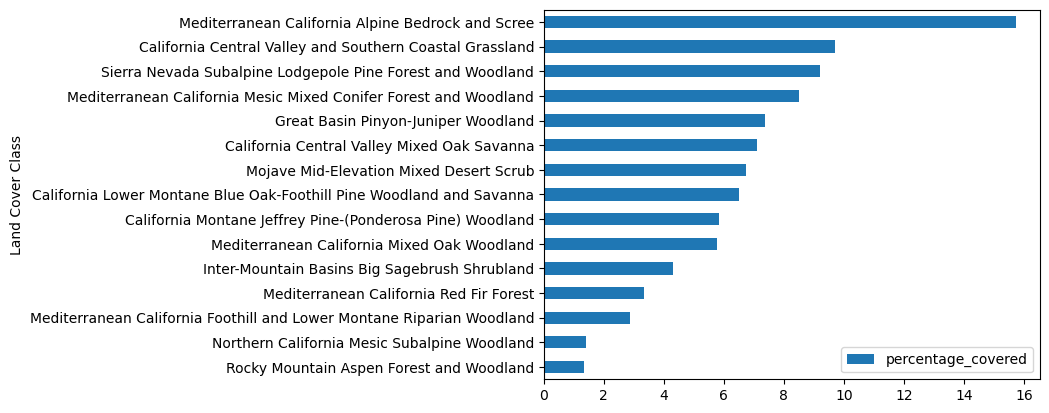

In [66]:
classes.loc[(classes['percentage_covered']>1)].sort_values(by='percentage_covered', ascending=True).plot.barh(x='class_label',
                                                        y='percentage_covered',
                                                                                                              xlabel = "Land Cover Class")

